# 필요한 라이브러리 import

In [44]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
import warnings
plt.rc('font',family='Malgun Gothic')
plt.rc('font',size=10)
from sklearn.metrics import mean_absolute_error
import pickle
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer,StandardScaler
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from itertools import combinations
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense,Input,Dropout
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.regularizers import L2
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import KFold
import tensorflow as tf
warnings.filterwarnings(action='ignore')

# 데이터로드

In [45]:
# 빈 데이터 프레임 생성

fm_data_df = pd.DataFrame(columns=['이름','포지션','골','도움','경기당 팀 득점/90',
                                 '경기당 팀 실점/90', 'Cr C/A', 'FA', '반칙 수/90', '기회 창출/90',
                                 '경기당 유효 슈팅/90', '경기당 슈팅/90', 'Int/90', '달린 거리/90분', 
                                 '공중 A/90', '태클 성공률','경기당 패스 시도/90', '경기당 패스 성공/90', 
                                 'K Ps/90', '태클 성공/90', '드리블 성공/90', 
                                 '헤더 성공/90', 'Cr A/90', '평균획득승점/경기'])

# 모든 데이터 프레임 이어붙이기
fm_data_df = pd.concat([fm_data_df,pd.read_csv('./datas/NEW_FM_DATA_FOR_ML/2021-2022/2021-2022ML.csv',encoding='utf-8-sig')])
fm_data_df = fm_data_df.reset_index(drop=True)
fm_data_df = pd.concat([fm_data_df,pd.read_csv('./datas/NEW_FM_DATA_FOR_ML/2022-2023/2022-2023ML.csv',encoding='utf-8-sig')])
fm_data_df = fm_data_df.reset_index(drop=True)
fm_data_df = pd.concat([fm_data_df,pd.read_csv('./datas/NEW_FM_DATA_FOR_ML/2023-2024/2023-2024ML.csv',encoding='utf-8-sig')])
fm_data_df = fm_data_df.reset_index(drop=True)

# 데이터 프레임 컬럼명 변경 및 자료형 변경
fm_data_df.rename(columns={'Cr C/A':'크로스 성공률','FA':'파울 획득','Int/90':'인터셉트/90','공중 A/90':'공중볼시도/90','K Ps/90':'키패스/90','Cr A/90':'크로스 시도/90'},inplace=True)
fm_data_df = fm_data_df.astype({'골':np.int64,'도움':np.int64,'파울 획득':np.int64,'태클 성공률':np.int64})

# 공격수만 추출
forward_df = fm_data_df[fm_data_df['포지션']=='공격수']

# 공격수 EDA

In [46]:
# 데이터 분석에 필요한 변수만 추출

num_col = [forward_df.columns[i] for i,x in enumerate(forward_df.dtypes) if x == 'int64' or x == 'float64']
features = list(set(num_col) - set(['평균획득승점/경기','출장시간','승','무','패','경기당 팀 득점/90','경기당 팀 실점/90']))
target = ['평균획득승점/경기']

## 이상치 확인

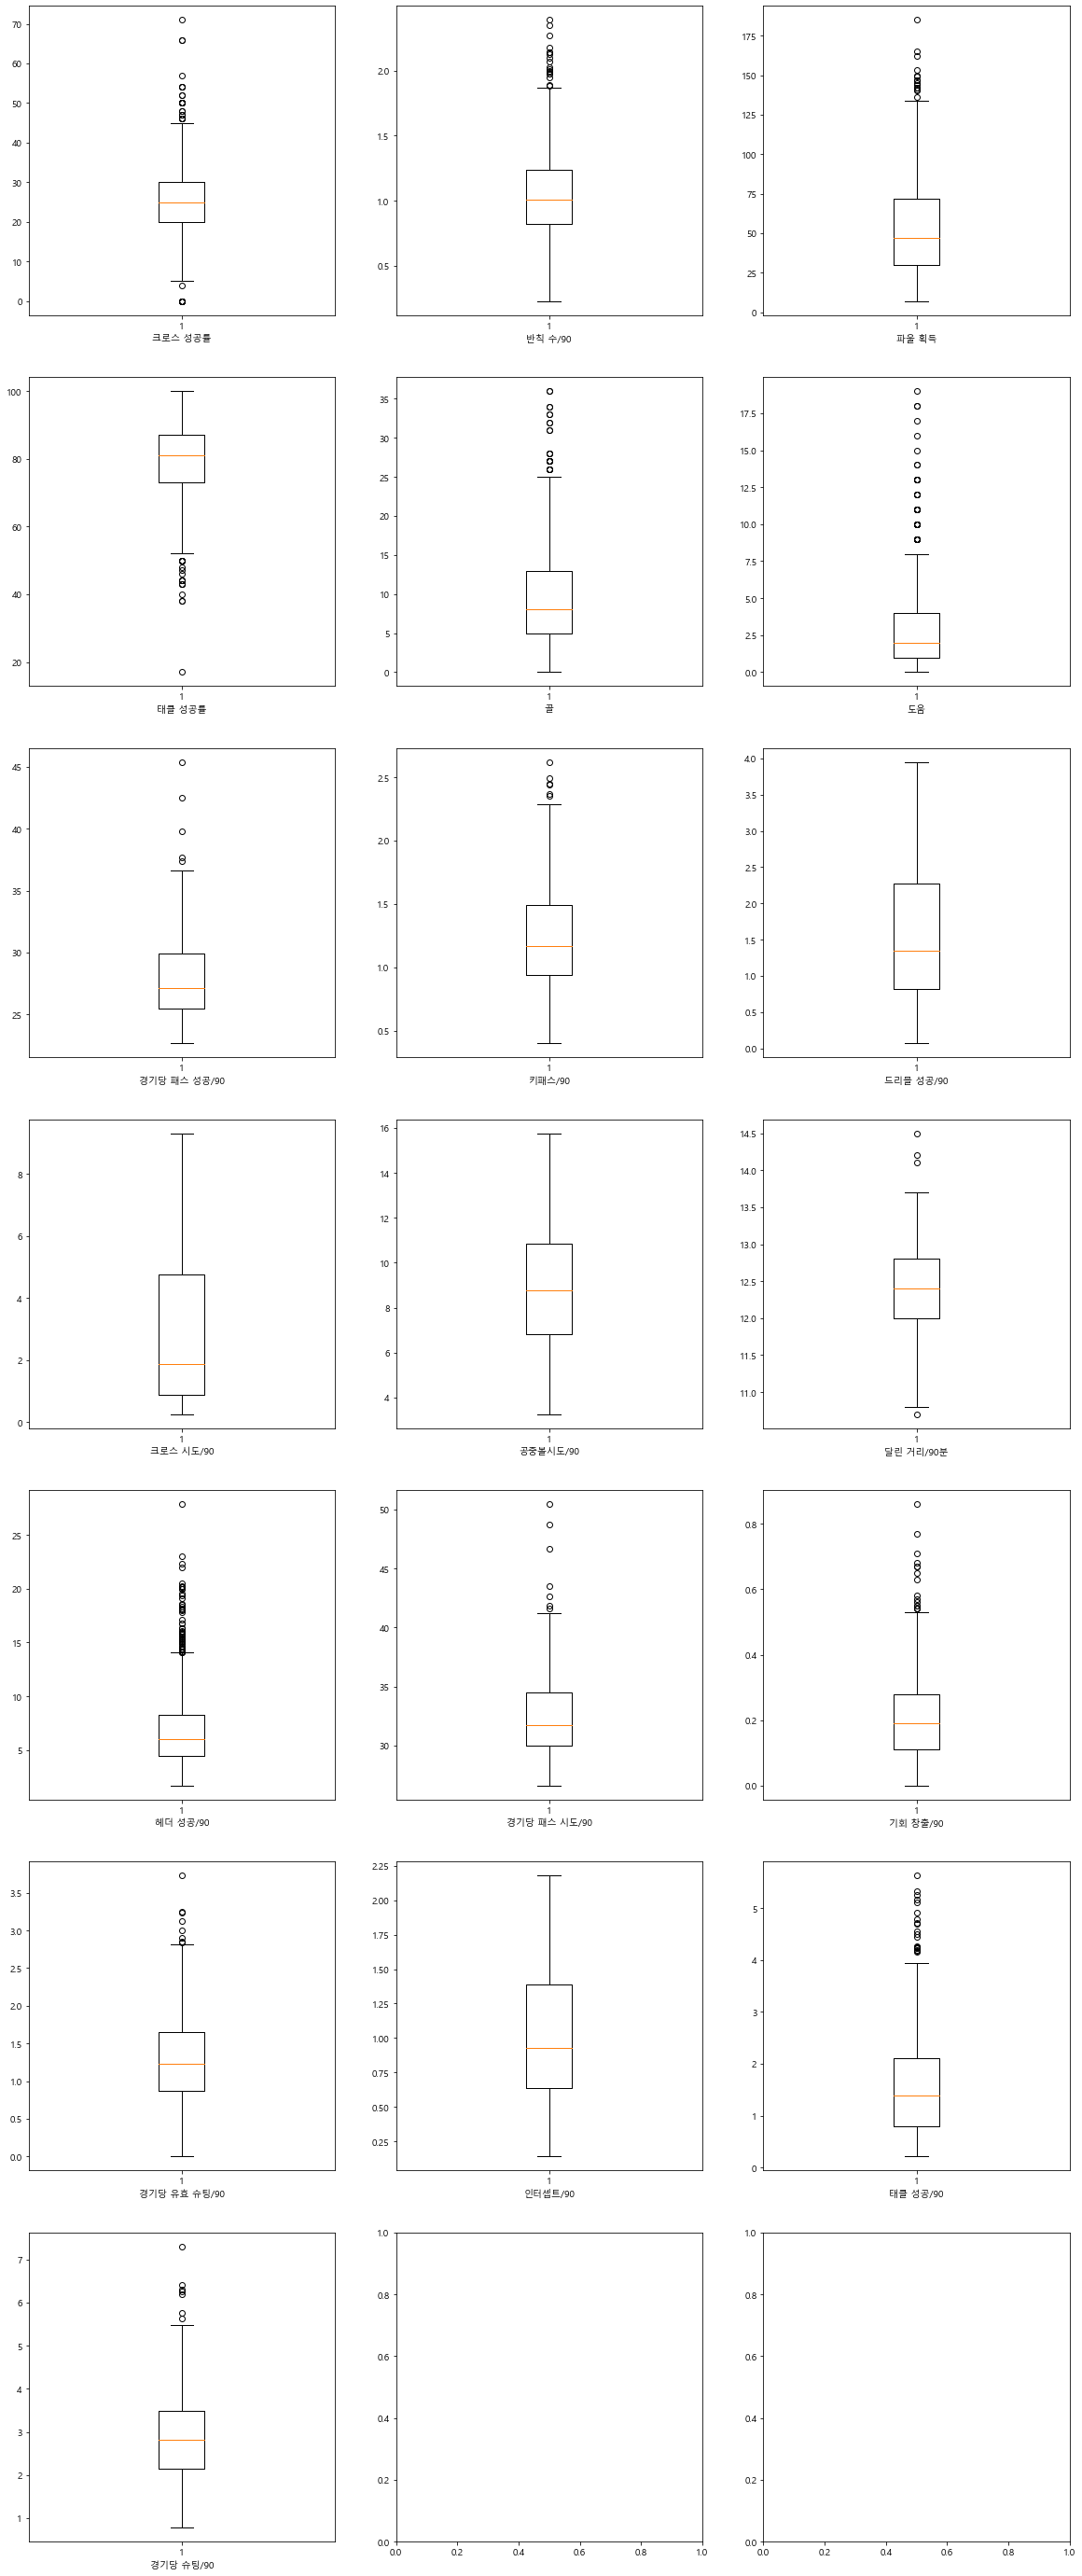

In [47]:
# 모든 변수의 Box plot 시각화

fig , axes = plt.subplots(7,3,figsize=(20,50))

for i, (ax,feature) in enumerate(zip(axes.ravel(),features)) :
    ax.set_xlabel(feature)
    ax.boxplot(forward_df.loc[:,feature])
    
plt.show()

In [48]:
# 데이터 당 이상치의 비율을 구하기
# 데이터는 990개인데 이상치가 그다지 많지 않다.
# 그래서 이상치의 비율이 5%가 넘는 변수만 tranformer를 적용한다.

out_ratio = defaultdict(float)

for feature in features:
    
    data = forward_df[feature].to_numpy()   
    Q1 = np.quantile(data,0.25)
    Q3 = np.quantile(data,0.7)
    low_bound = Q1 - 1.5 * (Q3-Q1)
    high_bound = Q3 + 1.5 * (Q3-Q1)
    out_ratio[feature] = (len(data[data>high_bound]) + len(data[data>=high_bound])) / len(data)

print(sorted(out_ratio.items(),key=lambda x : x[1],reverse=True))    
    
outlier_features = [k for k,v in out_ratio.items() if v > 0.05]
nonoutlier_features = list(set(features) - set(outlier_features))

[('헤더 성공/90', 0.16363636363636364), ('도움', 0.10505050505050505), ('태클 성공/90', 0.08282828282828283), ('골', 0.07272727272727272), ('반칙 수/90', 0.06464646464646465), ('기회 창출/90', 0.06060606060606061), ('크로스 성공률', 0.05858585858585859), ('파울 획득', 0.05656565656565657), ('키패스/90', 0.03838383838383838), ('경기당 패스 시도/90', 0.03434343434343434), ('경기당 유효 슈팅/90', 0.03434343434343434), ('경기당 슈팅/90', 0.022222222222222223), ('경기당 패스 성공/90', 0.014141414141414142), ('크로스 시도/90', 0.012121212121212121), ('달린 거리/90분', 0.006060606060606061), ('드리블 성공/90', 0.00202020202020202), ('태클 성공률', 0.0), ('공중볼시도/90', 0.0), ('인터셉트/90', 0.0)]


## 선형성 검정

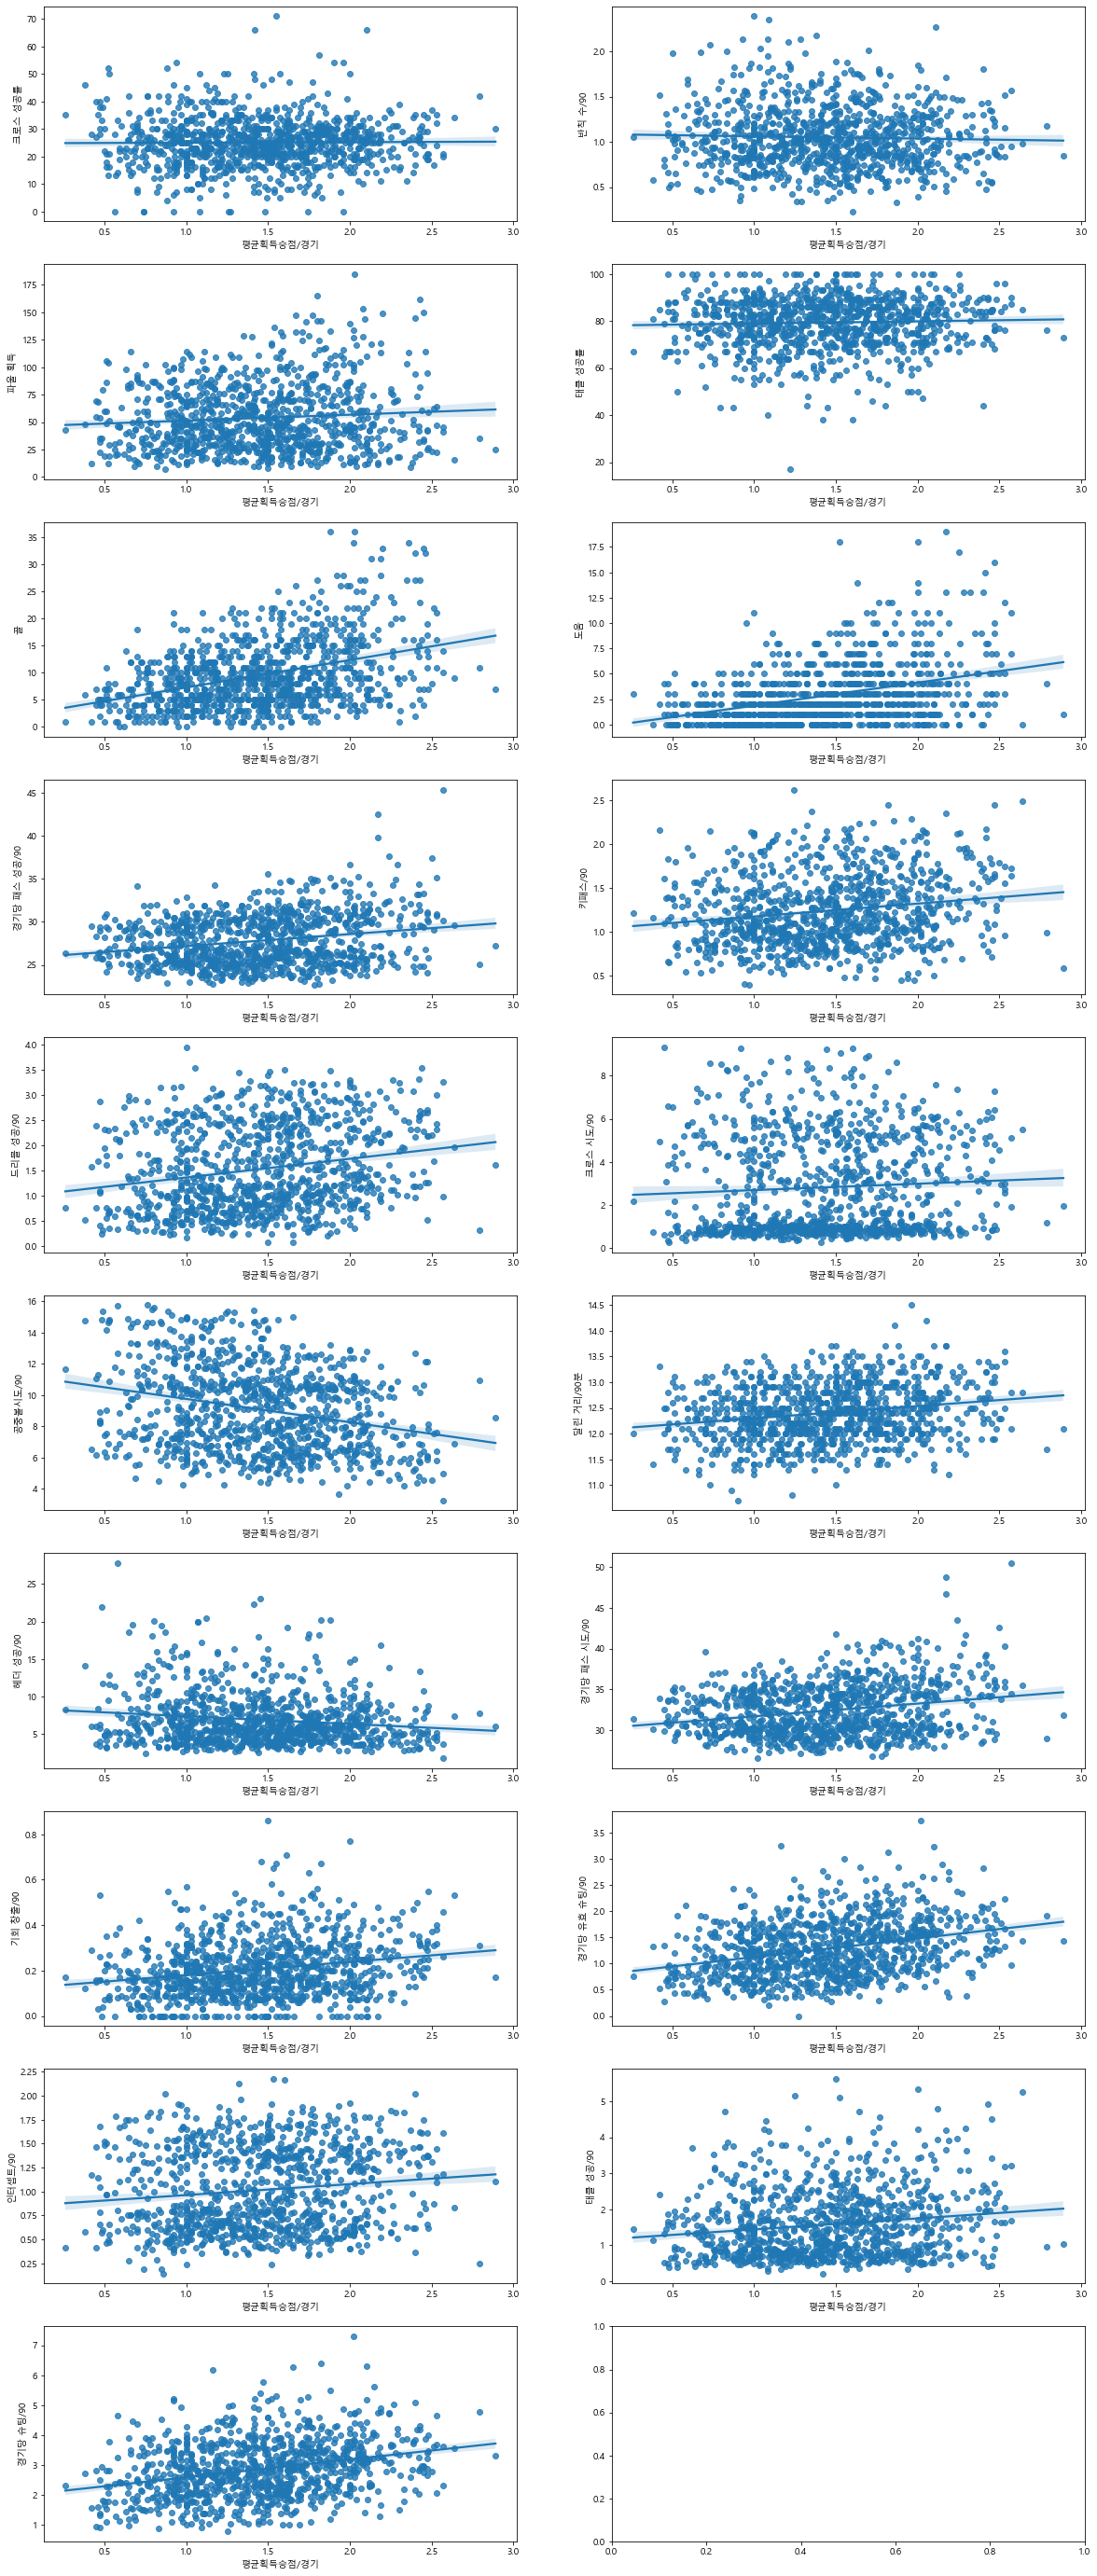

In [49]:
# scatter plot을 이용해서 선형성 검정
# 대부분의 피쳐가 선형성이 없어 보인다.

fig , axes = plt.subplots(10,2,figsize=(20,50))

for i, (ax,feature) in enumerate(zip(axes.ravel(),features)) :
    ax.set_ylabel(feature)
    ax.set_xlabel(target)
    sns.regplot(forward_df.loc[:,target],forward_df.loc[:,feature],ax=ax)
    
plt.show()

In [50]:
# target value와의 correlation을 가지고 선형성 확인

corr = [np.corrcoef(x ,y=forward_df.loc[:,target].T.values)[0][1] for x in forward_df.loc[:,features].T.values]

corr_dict = {}

for i,v in enumerate(corr):
    corr_dict[features[i]] = v

sorted(corr_dict.items(),key = lambda x : x[1],reverse=True)

[('골', 0.3899925372047754),
 ('도움', 0.3727750769369584),
 ('경기당 유효 슈팅/90', 0.3149008868945989),
 ('경기당 슈팅/90', 0.2943168941980925),
 ('경기당 패스 시도/90', 0.23483275556330324),
 ('경기당 패스 성공/90', 0.22567263258441708),
 ('기회 창출/90', 0.21355111596989557),
 ('드리블 성공/90', 0.21124806922396683),
 ('달린 거리/90분', 0.20850002371280105),
 ('키패스/90', 0.17434639122051926),
 ('태클 성공/90', 0.1533561266754542),
 ('인터셉트/90', 0.12639405293658518),
 ('파울 획득', 0.08483611536148467),
 ('크로스 시도/90', 0.06285626018412958),
 ('태클 성공률', 0.04108875139565955),
 ('크로스 성공률', 0.01034149433563985),
 ('반칙 수/90', -0.03516430428187815),
 ('헤더 성공/90', -0.14336317747602786),
 ('공중볼시도/90', -0.2635664616800462)]

## 정규성 검정

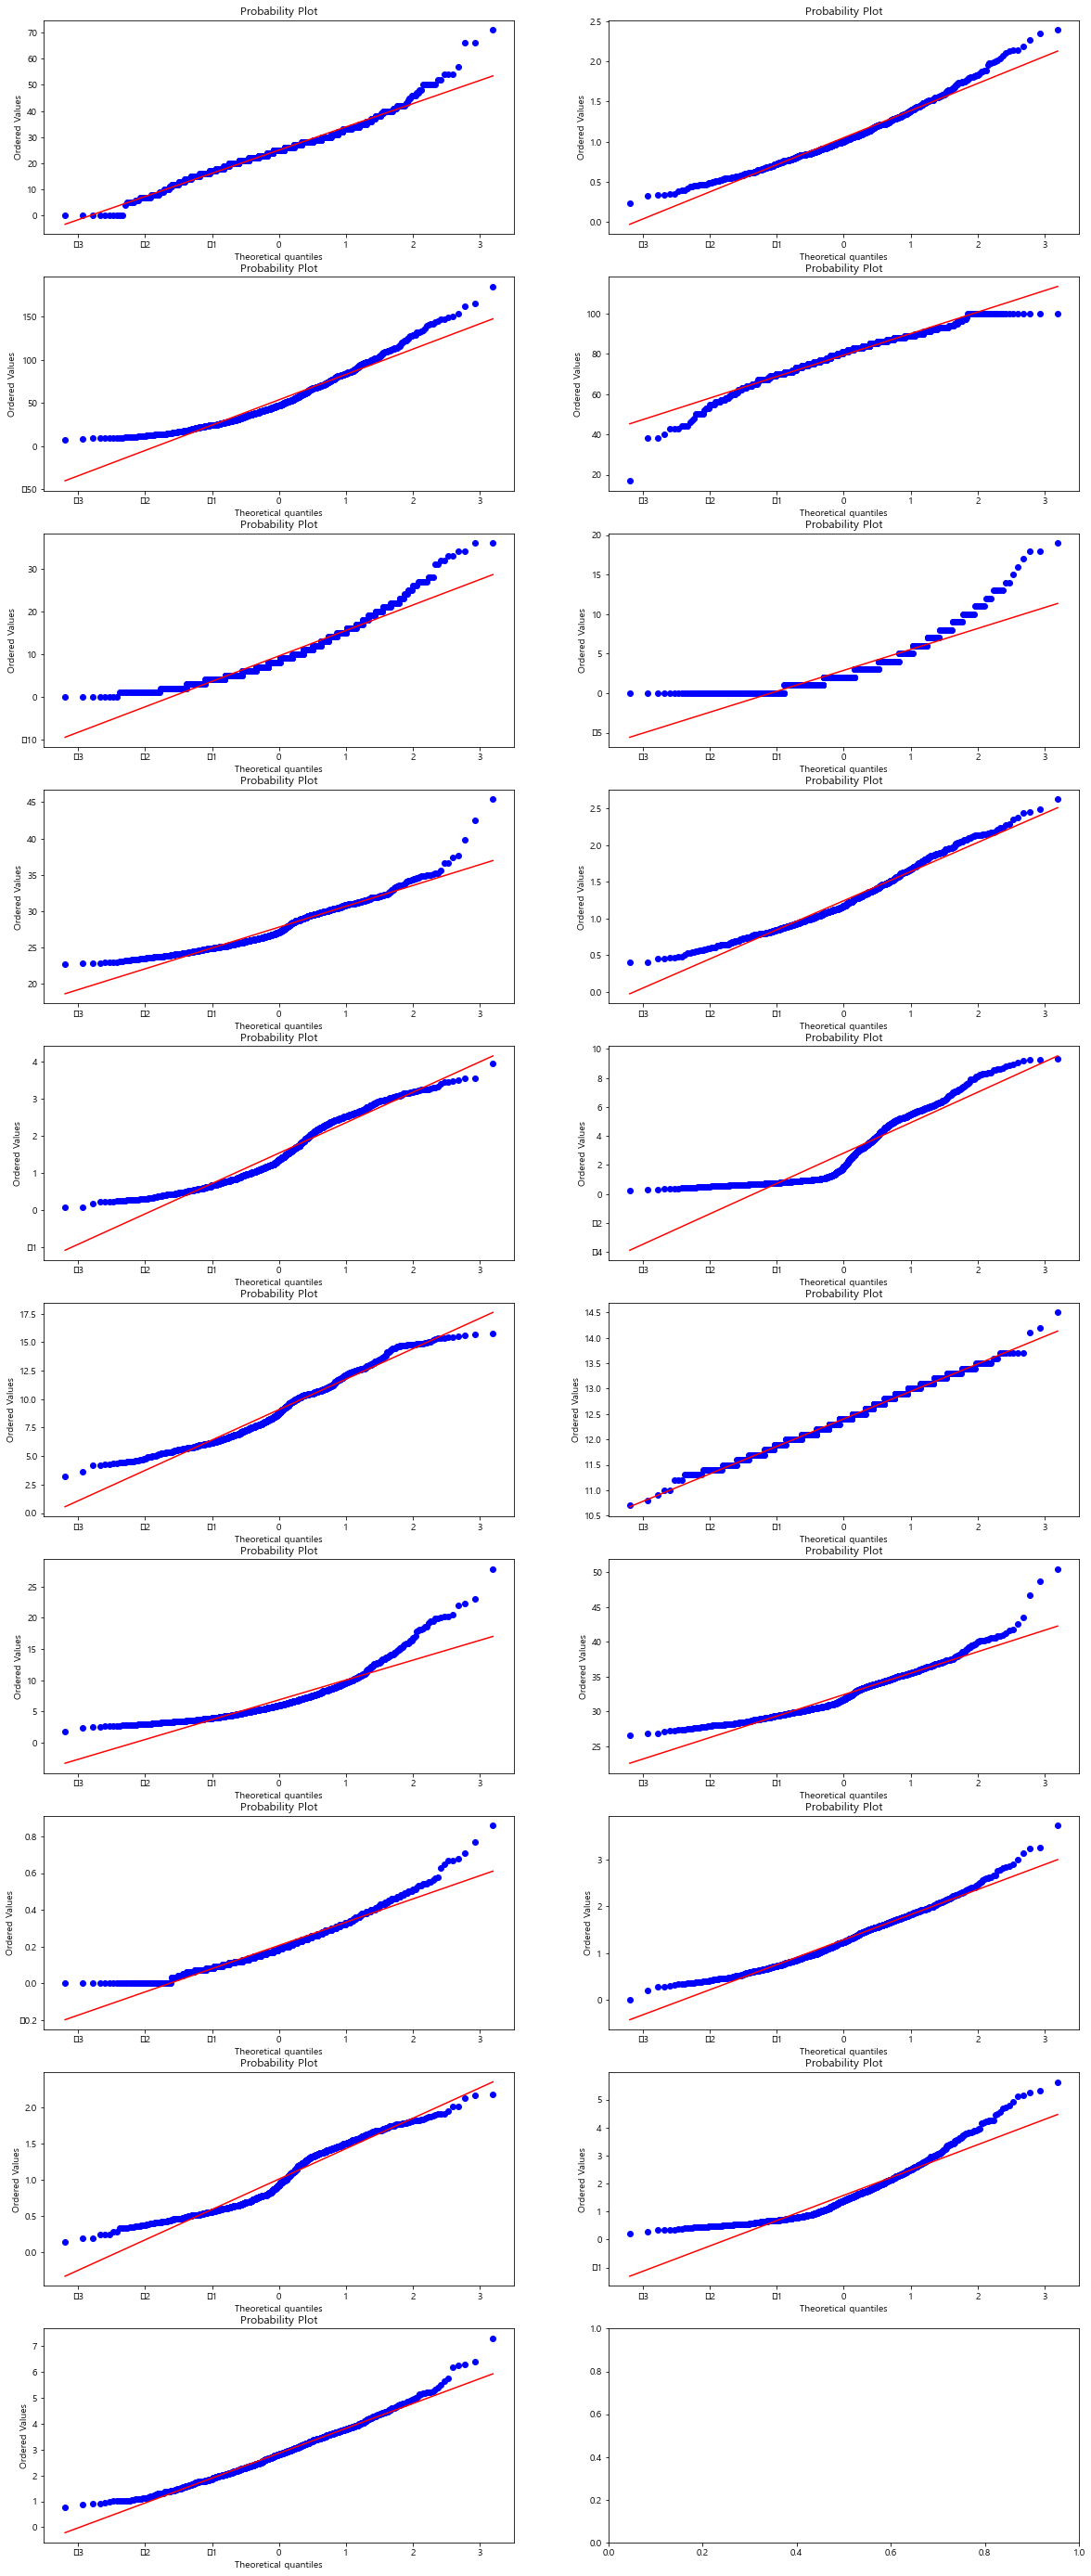

In [51]:
# QQ 플롯을 이용해서 정규성 시각화

fig , axes = plt.subplots(10,2,figsize=(20,50))

for i, (ax,feature) in enumerate(zip(axes.ravel(),features)) :
    ax.set_ylabel(feature)
    ax.set_xlabel(target)
    stats.probplot(forward_df.loc[:,feature],dist='norm',plot=ax)
    
plt.show()

In [52]:
# 모든 변수가 정규성을 만족하지 않는다.

shapiro_dict = {}

for feature in features:
    shapiro_dict[feature] = stats.shapiro(forward_df.loc[:,feature])
      
for k,v in shapiro_dict.items():
    if v[1] > 0.05:
        print(f'{k} 은/는 정규성을 만족한다. {v[1]} \n',)
        
    else:
        print(f'{k} 은/는 정규성을 만족하지 않는다.  {v[1]} \n')

크로스 성공률 은/는 정규성을 만족하지 않는다.  2.693583854226911e-12 

반칙 수/90 은/는 정규성을 만족하지 않는다.  5.135736020484005e-12 

파울 획득 은/는 정규성을 만족하지 않는다.  1.977547540519971e-19 

태클 성공률 은/는 정규성을 만족하지 않는다.  5.166333889693045e-15 

골 은/는 정규성을 만족하지 않는다.  9.412561093610319e-22 

도움 은/는 정규성을 만족하지 않는다.  5.289200778417567e-31 

경기당 패스 성공/90 은/는 정규성을 만족하지 않는다.  2.412282004970018e-18 

키패스/90 은/는 정규성을 만족하지 않는다.  1.5237267827691858e-12 

드리블 성공/90 은/는 정규성을 만족하지 않는다.  6.292405105902122e-18 

크로스 시도/90 은/는 정규성을 만족하지 않는다.  2.9994252397954525e-28 

공중볼시도/90 은/는 정규성을 만족하지 않는다.  1.5354534863617347e-13 

달린 거리/90분 은/는 정규성을 만족하지 않는다.  0.0004882311914116144 

헤더 성공/90 은/는 정규성을 만족하지 않는다.  1.4181624265947407e-29 

경기당 패스 시도/90 은/는 정규성을 만족하지 않는다.  7.358035729467315e-19 

기회 창출/90 은/는 정규성을 만족하지 않는다.  9.418115665384223e-17 

경기당 유효 슈팅/90 은/는 정규성을 만족하지 않는다.  4.7671561143047825e-11 

인터셉트/90 은/는 정규성을 만족하지 않는다.  3.53519002626841e-18 

태클 성공/90 은/는 정규성을 만족하지 않는다.  2.6788884093050553e-24 

경기당 슈팅/90 은/는 정규성을 만족하지 않는다.  1.4326889008486887e

## 등분산성 검정

In [53]:
# 변수간 등분산성을 만족하지 않는다.
stats.levene(*tuple([ tuple(x) for x in forward_df.loc[:,features].values]))

LeveneResult(statistic=0.1294975900958157, pvalue=0.9999999999999999)

## 다중 공선성 확인

In [54]:
this_vif = pd.DataFrame()
this_vif["VIF Factor"] = [vif(forward_df.loc[:,features].values,i) for i in range(forward_df.loc[:,features].values.shape[1])]
this_vif["feautures"] = forward_df.loc[:,features].columns
this_vif = this_vif.sort_values("VIF Factor").reset_index(drop=True)
this_vif

,VIF Factor,feautures
0,3.788092,도움
1,4.842201,기회 창출/90
2,9.795654,크로스 성공률
3,9.811395,크로스 시도/90
4,12.446589,반칙 수/90
5,12.987407,골
6,13.549914,태클 성공/90
7,15.434996,파울 획득
8,18.562202,헤더 성공/90
9,21.472031,드리블 성공/90


## 변수 정규화 및 변수 선택

### 변수 정규화

In [55]:
forward_qt = QuantileTransformer(n_quantiles=1000,output_distribution='normal').fit(forward_df.loc[:,outlier_features])
forward_df.loc[:,outlier_features] = forward_qt.transform(forward_df.loc[:,outlier_features])

forward_ss = StandardScaler().fit(forward_df.loc[:,nonoutlier_features])
forward_df.loc[:,nonoutlier_features] = forward_ss.transform(forward_df.loc[:,nonoutlier_features])

In [56]:
outlier_features

['크로스 성공률', '반칙 수/90', '파울 획득', '골', '도움', '헤더 성공/90', '기회 창출/90', '태클 성공/90']

In [57]:
nonoutlier_features

['공중볼시도/90',
 '경기당 패스 성공/90',
 '달린 거리/90분',
 '경기당 유효 슈팅/90',
 '드리블 성공/90',
 '키패스/90',
 '인터셉트/90',
 '태클 성공률',
 '크로스 시도/90',
 '경기당 슈팅/90',
 '경기당 패스 시도/90']

In [58]:
with open('./models/forward_qt.pickle','wb') as f:
    pickle.dump(forward_qt,f)
    
with open('./models/forward_ss.pickle','wb') as f:
    pickle.dump(forward_ss,f)

### 상관계수와 시각화를 통한 변수 선택

In [16]:
feature_comb = list(combinations(features,2))

In [17]:
'''
fig , axes = plt.subplots(43,4,figsize=(100,860))

for i,(ax,feature) in enumerate(zip(axes.ravel(),feature_comb)):
    sns.scatterplot(x = forward_df.loc[:,feature[0]], y= forward_df.loc[:,feature[1]],ax=ax)
'''

'\nfig , axes = plt.subplots(43,4,figsize=(100,860))\n\nfor i,(ax,feature) in enumerate(zip(axes.ravel(),feature_comb)):\n    sns.scatterplot(x = forward_df.loc[:,feature[0]], y= forward_df.loc[:,feature[1]],ax=ax)\n'

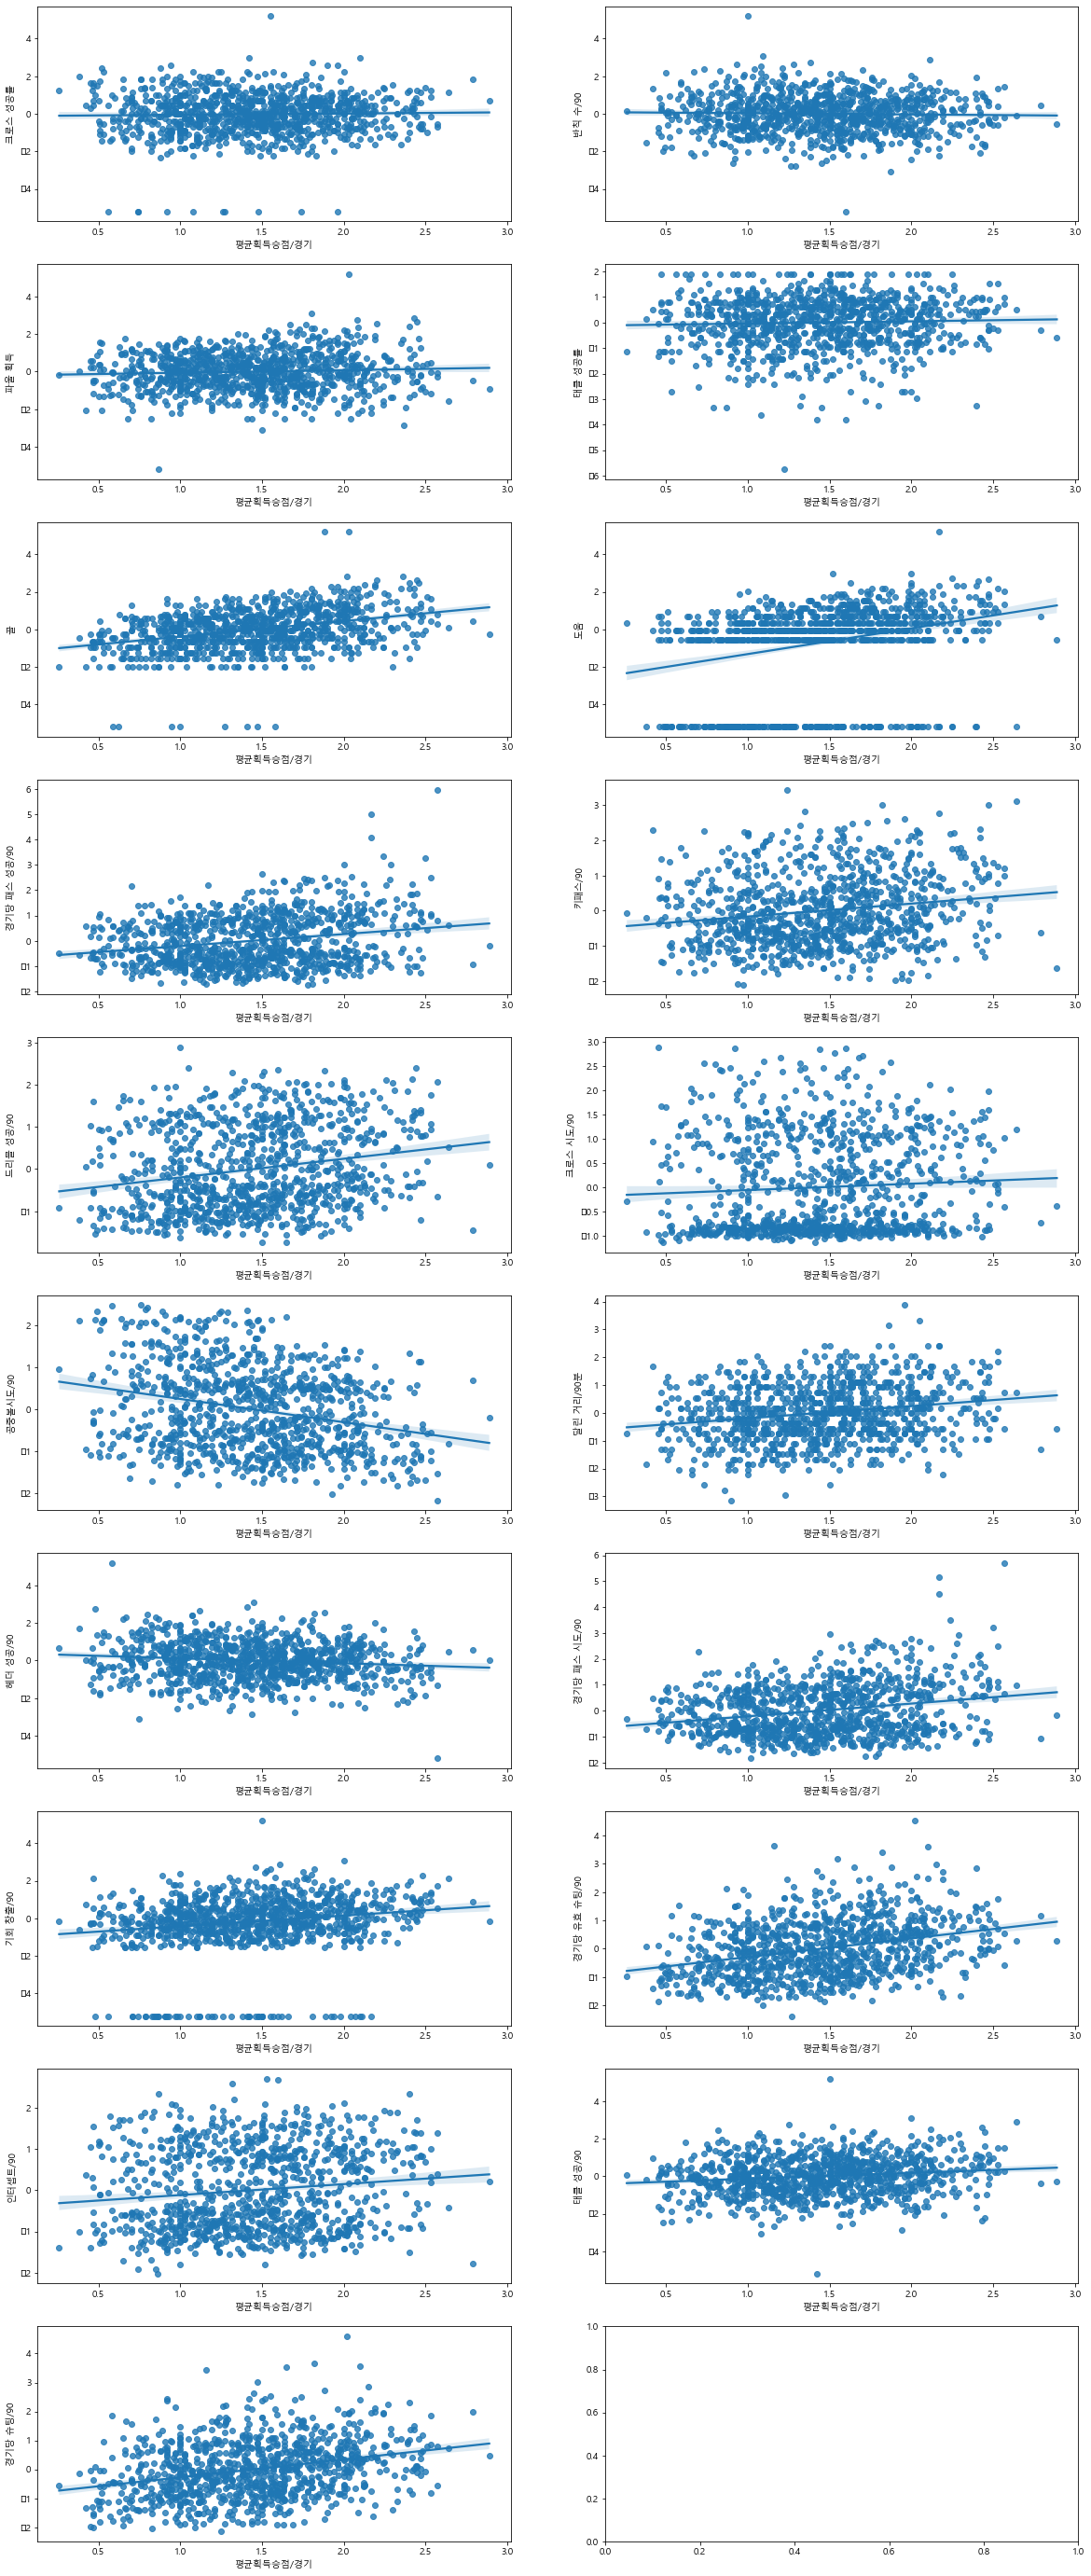

In [18]:
fig , axes = plt.subplots(10,2,figsize=(20,50))

for i, (ax,feature) in enumerate(zip(axes.ravel(),features)) :
    ax.set_ylabel(feature)
    ax.set_xlabel(target)
    sns.regplot(forward_df.loc[:,target],forward_df.loc[:,feature],ax=ax)
    
plt.show()

In [19]:
corr_dict_after_norm = {}

for feature in features:
    corr_dict_after_norm[f'크로스 성공률/{feature}'] = np.corrcoef(forward_df.loc[:,'크로스 성공률'],forward_df.loc[:,feature])[0][1]
    
sorted(corr_dict_after_norm.items(),key=lambda x : np.abs(x[1]),reverse=True)

[('크로스 성공률/크로스 성공률', 1.0),
 ('크로스 성공률/태클 성공률', -0.20319448438904755),
 ('크로스 성공률/드리블 성공/90', 0.10307162310939814),
 ('크로스 성공률/기회 창출/90', 0.07660657508845373),
 ('크로스 성공률/키패스/90', 0.07286859410213331),
 ('크로스 성공률/크로스 시도/90', 0.071114965392636),
 ('크로스 성공률/인터셉트/90', 0.06535223315393826),
 ('크로스 성공률/반칙 수/90', 0.06199179519018697),
 ('크로스 성공률/경기당 패스 시도/90', 0.0552863341389583),
 ('크로스 성공률/공중볼시도/90', -0.054255048905250555),
 ('크로스 성공률/달린 거리/90분', 0.049003509569561086),
 ('크로스 성공률/도움', 0.03511560132420468),
 ('크로스 성공률/헤더 성공/90', -0.03223267837408495),
 ('크로스 성공률/경기당 슈팅/90', -0.02709502618807057),
 ('크로스 성공률/경기당 패스 성공/90', 0.02137222338782902),
 ('크로스 성공률/경기당 유효 슈팅/90', -0.01450646206396306),
 ('크로스 성공률/골', -0.006848120498843884),
 ('크로스 성공률/태클 성공/90', -0.006689018858190929),
 ('크로스 성공률/파울 획득', -0.0019169934698966928)]

In [20]:
sorted(corr_dict.items(),key=lambda x : np.abs(x[1]),reverse=True)

[('골', 0.3899925372047754),
 ('도움', 0.3727750769369584),
 ('경기당 유효 슈팅/90', 0.3149008868945989),
 ('경기당 슈팅/90', 0.2943168941980925),
 ('공중볼시도/90', -0.2635664616800462),
 ('경기당 패스 시도/90', 0.23483275556330324),
 ('경기당 패스 성공/90', 0.22567263258441708),
 ('기회 창출/90', 0.21355111596989557),
 ('드리블 성공/90', 0.21124806922396683),
 ('달린 거리/90분', 0.20850002371280105),
 ('키패스/90', 0.17434639122051926),
 ('태클 성공/90', 0.1533561266754542),
 ('헤더 성공/90', -0.14336317747602786),
 ('인터셉트/90', 0.12639405293658518),
 ('파울 획득', 0.08483611536148467),
 ('크로스 시도/90', 0.06285626018412958),
 ('태클 성공률', 0.04108875139565955),
 ('반칙 수/90', -0.03516430428187815),
 ('크로스 성공률', 0.01034149433563985)]

In [27]:
# 상관계수가 높은 변수

# 전진선택법을 위한 변수의 우선순위 순 
# 인터셉트,

good_feature_order = ['골','도움','경기당 유효 슈팅/90','공중볼시도/90','경기당 패스 시도/90',
                      '기회 창출/90','드리블 성공/90','크로스 성공률']

forward_mae = []
forward_model = []

for i in range(1,len(good_feature_order)+1):
    
    print(good_feature_order[:i])
    
    fx_train,fx_test,fy_train,fy_test = train_test_split(forward_df.loc[:,good_feature_order[:i]],forward_df.loc[:,target],test_size=0.2)
    
    inputs_layer = Input(shape=(i,))
    hidden1 = Dense(128,activation='relu')(inputs_layer)
    hidden2 = Dense(64,activation='relu')(hidden1)
    hidden3 = Dense(32,activation='relu')(hidden2)
    output = Dense(1,activation='linear')(hidden3)
    model = Model(inputs=[inputs_layer],outputs=[output])
    model.compile(loss='mse',optimizer=Adam(lr=0.001))
    
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=100)
    model.fit(fx_train,fy_train,batch_size=70,epochs=50,validation_data=(fx_test,fy_test))  
    predict_result=model.predict(fx_test)
    mae = mean_absolute_error(fy_test,predict_result)
    forward_mae.append(mae)
    forward_model.append(model)

['골']
Epoch 1/50
12/12 [==============================] - 1s 32ms/step - loss: 1.6025 - val_loss: 0.9805
Epoch 2/50
12/12 [==============================] - 0s 5ms/step - loss: 0.8474 - val_loss: 0.6011
Epoch 3/50
12/12 [==============================] - 0s 5ms/step - loss: 0.6292 - val_loss: 0.4160
Epoch 4/50
12/12 [==============================] - 0s 5ms/step - loss: 0.4328 - val_loss: 0.2950
Epoch 5/50
12/12 [==============================] - 0s 5ms/step - loss: 0.3041 - val_loss: 0.2116
Epoch 6/50
12/12 [==============================] - 0s 5ms/step - loss: 0.2288 - val_loss: 0.1914
Epoch 7/50
12/12 [==============================] - 0s 5ms/step - loss: 0.2058 - val_loss: 0.1840
Epoch 8/50
12/12 [==============================] - 0s 6ms/step - loss: 0.1998 - val_loss: 0.1930
Epoch 9/50
12/12 [==============================] - 0s 6ms/step - loss: 0.2006 - val_loss: 0.1915
Epoch 10/50
12/12 [==============================] - 0s 6ms/step - loss: 0.1982 - val_loss: 0.1918
Epoch 11/50


12/12 [==============================] - 0s 5ms/step - loss: 0.1801 - val_loss: 0.1870
Epoch 34/50
12/12 [==============================] - 0s 6ms/step - loss: 0.1776 - val_loss: 0.1829
Epoch 35/50
12/12 [==============================] - 0s 5ms/step - loss: 0.1777 - val_loss: 0.1862
Epoch 36/50
12/12 [==============================] - 0s 5ms/step - loss: 0.1753 - val_loss: 0.1846
Epoch 37/50
12/12 [==============================] - 0s 5ms/step - loss: 0.1788 - val_loss: 0.1893
Epoch 38/50
12/12 [==============================] - 0s 5ms/step - loss: 0.1754 - val_loss: 0.1835
Epoch 39/50
12/12 [==============================] - 0s 5ms/step - loss: 0.1763 - val_loss: 0.1875
Epoch 40/50
12/12 [==============================] - 0s 5ms/step - loss: 0.1750 - val_loss: 0.1859
Epoch 41/50
12/12 [==============================] - 0s 5ms/step - loss: 0.1748 - val_loss: 0.1880
Epoch 42/50
12/12 [==============================] - 0s 5ms/step - loss: 0.1758 - val_loss: 0.1835
Epoch 43/50
12/12 [===

12/12 [==============================] - 0s 4ms/step - loss: 0.1306 - val_loss: 0.1732
Epoch 16/50
12/12 [==============================] - 0s 4ms/step - loss: 0.1274 - val_loss: 0.1706
Epoch 17/50
12/12 [==============================] - 0s 4ms/step - loss: 0.1256 - val_loss: 0.1664
Epoch 18/50
12/12 [==============================] - 0s 4ms/step - loss: 0.1240 - val_loss: 0.1699
Epoch 19/50
12/12 [==============================] - 0s 4ms/step - loss: 0.1230 - val_loss: 0.1644
Epoch 20/50
12/12 [==============================] - 0s 4ms/step - loss: 0.1216 - val_loss: 0.1645
Epoch 21/50
12/12 [==============================] - 0s 4ms/step - loss: 0.1208 - val_loss: 0.1626
Epoch 22/50
12/12 [==============================] - 0s 4ms/step - loss: 0.1219 - val_loss: 0.1648
Epoch 23/50
12/12 [==============================] - 0s 4ms/step - loss: 0.1201 - val_loss: 0.1599
Epoch 24/50
12/12 [==============================] - 0s 4ms/step - loss: 0.1216 - val_loss: 0.1631
Epoch 25/50
12/12 [===

12/12 [==============================] - 0s 4ms/step - loss: 0.1101 - val_loss: 0.1237
Epoch 48/50
12/12 [==============================] - 0s 4ms/step - loss: 0.1084 - val_loss: 0.1238
Epoch 49/50
12/12 [==============================] - 0s 4ms/step - loss: 0.1096 - val_loss: 0.1221
Epoch 50/50
12/12 [==============================] - 0s 4ms/step - loss: 0.1063 - val_loss: 0.1233
['골', '도움', '경기당 유효 슈팅/90', '공중볼시도/90', '경기당 패스 시도/90', '기회 창출/90']
Epoch 1/50
12/12 [==============================] - 0s 11ms/step - loss: 1.3298 - val_loss: 0.6838
Epoch 2/50
12/12 [==============================] - 0s 4ms/step - loss: 0.4217 - val_loss: 0.3413
Epoch 3/50
12/12 [==============================] - 0s 4ms/step - loss: 0.3332 - val_loss: 0.3245
Epoch 4/50
12/12 [==============================] - 0s 4ms/step - loss: 0.2682 - val_loss: 0.2603
Epoch 5/50
12/12 [==============================] - 0s 4ms/step - loss: 0.2383 - val_loss: 0.2552
Epoch 6/50
12/12 [==============================] - 0s 4m

12/12 [==============================] - 0s 4ms/step - loss: 0.0983 - val_loss: 0.1164
Epoch 29/50
12/12 [==============================] - 0s 4ms/step - loss: 0.1005 - val_loss: 0.1134
Epoch 30/50
12/12 [==============================] - 0s 4ms/step - loss: 0.0994 - val_loss: 0.1240
Epoch 31/50
12/12 [==============================] - 0s 4ms/step - loss: 0.0969 - val_loss: 0.1246
Epoch 32/50
12/12 [==============================] - 0s 4ms/step - loss: 0.0977 - val_loss: 0.1191
Epoch 33/50
12/12 [==============================] - 0s 4ms/step - loss: 0.0962 - val_loss: 0.1184
Epoch 34/50
12/12 [==============================] - 0s 4ms/step - loss: 0.0922 - val_loss: 0.1218
Epoch 35/50
12/12 [==============================] - 0s 4ms/step - loss: 0.0913 - val_loss: 0.1170
Epoch 36/50
12/12 [==============================] - 0s 4ms/step - loss: 0.0917 - val_loss: 0.1253
Epoch 37/50
12/12 [==============================] - 0s 4ms/step - loss: 0.0917 - val_loss: 0.1194
Epoch 38/50
12/12 [===

In [28]:
forward_mae

[0.3538202710585161,
 0.35436266210344103,
 0.32634570124173407,
 0.3264726907195467,
 0.2729317567565224,
 0.32388039783997963,
 0.2758005033478592,
 0.32796706817366866]

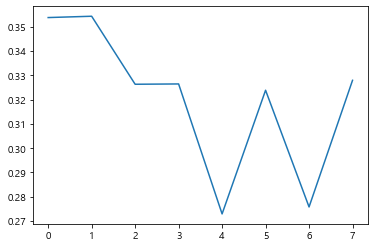

In [29]:
plt.plot(forward_mae)
plt.show()

In [39]:
good_features = good_feature_order[0:4]
#good_features.append(good_feature_order[6])
good_features

['골', '도움', '경기당 유효 슈팅/90', '공중볼시도/90']

In [40]:
fx_train,fx_test,fy_train,fy_test = train_test_split(forward_df.loc[:,good_features],forward_df.loc[:,target],test_size=0.2)

In [41]:
inputs_layer = Input(shape=(len(good_features),))
hidden1 = Dense(2048,activation='relu',kernel_regularizer=L2(l2=0.01))(inputs_layer)
hidden2 = Dense(1024,activation='relu',kernel_regularizer=L2(l2=0.01))(hidden1)
hidden3 = Dropout(0.1)(hidden2)
hidden4 = Dense(512,activation='relu',kernel_regularizer=L2(l2=0.01))(hidden3)
hidden5 = Dense(256,activation='relu')(hidden4)
hidden6 = Dropout(0.1)(hidden5)
hidden7 = Dense(128,activation='relu')(hidden6)
hidden8 = Dense(64,activation='relu')(hidden7)
hidden9 = Dense(32,activation='relu')(hidden8)
hidden10 = Dense(16,activation='relu')(hidden9)
output = Dense(1,activation='linear')(hidden10)
model = Model(inputs=[inputs_layer],outputs=[output])
model.compile(loss='mse',optimizer=Adam(lr=0.0005)) 
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=100)
model.fit(fx_train,fy_train,batch_size=40,epochs=600,validation_data=(fx_test,fy_test))  
predict_result=model.predict(fx_test)
mae = mean_absolute_error(fy_test,predict_result)
print(mae)
model.save('./models/forward_nn.h5')

Epoch 1/600
20/20 [==============================] - 1s 24ms/step - loss: 17.1247 - val_loss: 12.4473
Epoch 2/600
20/20 [==============================] - 0s 8ms/step - loss: 9.5895 - val_loss: 6.8907
Epoch 3/600
20/20 [==============================] - 0s 8ms/step - loss: 5.3421 - val_loss: 3.8468
Epoch 4/600
20/20 [==============================] - 0s 8ms/step - loss: 3.0037 - val_loss: 2.2181
Epoch 5/600
20/20 [==============================] - 0s 8ms/step - loss: 1.7737 - val_loss: 1.3606
Epoch 6/600
20/20 [==============================] - 0s 8ms/step - loss: 1.1156 - val_loss: 0.8782
Epoch 7/600
20/20 [==============================] - 0s 8ms/step - loss: 0.7530 - val_loss: 0.6095
Epoch 8/600
20/20 [==============================] - 0s 7ms/step - loss: 0.5476 - val_loss: 0.4573
Epoch 9/600
20/20 [==============================] - 0s 8ms/step - loss: 0.4187 - val_loss: 0.3644
Epoch 10/600
20/20 [==============================] - 0s 7ms/step - loss: 0.3404 - val_loss: 0.3054
Epoch 

Epoch 83/600
20/20 [==============================] - 0s 7ms/step - loss: 0.1510 - val_loss: 0.1461
Epoch 84/600
20/20 [==============================] - 0s 7ms/step - loss: 0.1635 - val_loss: 0.1554
Epoch 85/600
20/20 [==============================] - 0s 7ms/step - loss: 0.1511 - val_loss: 0.1457
Epoch 86/600
20/20 [==============================] - 0s 7ms/step - loss: 0.1530 - val_loss: 0.1444
Epoch 87/600
20/20 [==============================] - 0s 7ms/step - loss: 0.1495 - val_loss: 0.1443
Epoch 88/600
20/20 [==============================] - 0s 7ms/step - loss: 0.1583 - val_loss: 0.1625
Epoch 89/600
20/20 [==============================] - 0s 7ms/step - loss: 0.1546 - val_loss: 0.1417
Epoch 90/600
20/20 [==============================] - 0s 7ms/step - loss: 0.1493 - val_loss: 0.1439
Epoch 91/600
20/20 [==============================] - 0s 7ms/step - loss: 0.1498 - val_loss: 0.1420
Epoch 92/600
20/20 [==============================] - 0s 7ms/step - loss: 0.1458 - val_loss: 0.1405


20/20 [==============================] - 0s 7ms/step - loss: 0.1454 - val_loss: 0.1438
Epoch 165/600
20/20 [==============================] - 0s 7ms/step - loss: 0.1444 - val_loss: 0.1363
Epoch 166/600
20/20 [==============================] - 0s 7ms/step - loss: 0.1448 - val_loss: 0.1383
Epoch 167/600
20/20 [==============================] - 0s 7ms/step - loss: 0.1468 - val_loss: 0.1401
Epoch 168/600
20/20 [==============================] - 0s 7ms/step - loss: 0.1471 - val_loss: 0.1372
Epoch 169/600
20/20 [==============================] - 0s 7ms/step - loss: 0.1419 - val_loss: 0.1359
Epoch 170/600
20/20 [==============================] - 0s 7ms/step - loss: 0.1418 - val_loss: 0.1381
Epoch 171/600
20/20 [==============================] - 0s 7ms/step - loss: 0.1487 - val_loss: 0.1526
Epoch 172/600
20/20 [==============================] - 0s 7ms/step - loss: 0.1475 - val_loss: 0.1390
Epoch 173/600
20/20 [==============================] - 0s 7ms/step - loss: 0.1479 - val_loss: 0.1391
Epoc

20/20 [==============================] - 0s 7ms/step - loss: 0.1424 - val_loss: 0.1381
Epoch 246/600
20/20 [==============================] - 0s 7ms/step - loss: 0.1439 - val_loss: 0.1376
Epoch 247/600
20/20 [==============================] - 0s 7ms/step - loss: 0.1470 - val_loss: 0.1402
Epoch 248/600
20/20 [==============================] - 0s 7ms/step - loss: 0.1519 - val_loss: 0.1390
Epoch 249/600
20/20 [==============================] - 0s 7ms/step - loss: 0.1429 - val_loss: 0.1354
Epoch 250/600
20/20 [==============================] - 0s 7ms/step - loss: 0.1426 - val_loss: 0.1449
Epoch 251/600
20/20 [==============================] - 0s 7ms/step - loss: 0.1486 - val_loss: 0.1412
Epoch 252/600
20/20 [==============================] - 0s 7ms/step - loss: 0.1432 - val_loss: 0.1458
Epoch 253/600
20/20 [==============================] - 0s 7ms/step - loss: 0.1404 - val_loss: 0.1373
Epoch 254/600
20/20 [==============================] - 0s 7ms/step - loss: 0.1438 - val_loss: 0.1758
Epoc

20/20 [==============================] - 0s 7ms/step - loss: 0.1423 - val_loss: 0.1391
Epoch 327/600
20/20 [==============================] - 0s 7ms/step - loss: 0.1411 - val_loss: 0.1354
Epoch 328/600
20/20 [==============================] - 0s 7ms/step - loss: 0.1397 - val_loss: 0.1385
Epoch 329/600
20/20 [==============================] - 0s 7ms/step - loss: 0.1380 - val_loss: 0.1418
Epoch 330/600
20/20 [==============================] - 0s 7ms/step - loss: 0.1421 - val_loss: 0.1411
Epoch 331/600
20/20 [==============================] - 0s 7ms/step - loss: 0.1419 - val_loss: 0.1464
Epoch 332/600
20/20 [==============================] - 0s 7ms/step - loss: 0.1418 - val_loss: 0.1397
Epoch 333/600
20/20 [==============================] - 0s 7ms/step - loss: 0.1420 - val_loss: 0.1354
Epoch 334/600
20/20 [==============================] - 0s 8ms/step - loss: 0.1436 - val_loss: 0.1441
Epoch 335/600
20/20 [==============================] - 0s 8ms/step - loss: 0.1394 - val_loss: 0.1371
Epoc

20/20 [==============================] - 0s 7ms/step - loss: 0.1436 - val_loss: 0.1381
Epoch 408/600
20/20 [==============================] - 0s 7ms/step - loss: 0.1375 - val_loss: 0.1355
Epoch 409/600
20/20 [==============================] - 0s 7ms/step - loss: 0.1376 - val_loss: 0.1383
Epoch 410/600
20/20 [==============================] - 0s 7ms/step - loss: 0.1385 - val_loss: 0.1350
Epoch 411/600
20/20 [==============================] - 0s 7ms/step - loss: 0.1388 - val_loss: 0.1356
Epoch 412/600
20/20 [==============================] - 0s 7ms/step - loss: 0.1369 - val_loss: 0.1372
Epoch 413/600
20/20 [==============================] - 0s 7ms/step - loss: 0.1368 - val_loss: 0.1353
Epoch 414/600
20/20 [==============================] - 0s 7ms/step - loss: 0.1374 - val_loss: 0.1346
Epoch 415/600
20/20 [==============================] - 0s 7ms/step - loss: 0.1408 - val_loss: 0.1387
Epoch 416/600
20/20 [==============================] - 0s 7ms/step - loss: 0.1401 - val_loss: 0.1375
Epoc

20/20 [==============================] - 0s 7ms/step - loss: 0.1392 - val_loss: 0.1379
Epoch 489/600
20/20 [==============================] - 0s 7ms/step - loss: 0.1425 - val_loss: 0.1390
Epoch 490/600
20/20 [==============================] - 0s 7ms/step - loss: 0.1370 - val_loss: 0.1382
Epoch 491/600
20/20 [==============================] - 0s 7ms/step - loss: 0.1370 - val_loss: 0.1377
Epoch 492/600
20/20 [==============================] - 0s 7ms/step - loss: 0.1364 - val_loss: 0.1381
Epoch 493/600
20/20 [==============================] - 0s 7ms/step - loss: 0.1378 - val_loss: 0.1360
Epoch 494/600
20/20 [==============================] - 0s 7ms/step - loss: 0.1369 - val_loss: 0.1443
Epoch 495/600
20/20 [==============================] - 0s 7ms/step - loss: 0.1366 - val_loss: 0.1432
Epoch 496/600
20/20 [==============================] - 0s 7ms/step - loss: 0.1364 - val_loss: 0.1389
Epoch 497/600
20/20 [==============================] - 0s 7ms/step - loss: 0.1378 - val_loss: 0.1398
Epoc

20/20 [==============================] - 0s 7ms/step - loss: 0.1347 - val_loss: 0.1439
Epoch 570/600
20/20 [==============================] - 0s 7ms/step - loss: 0.1382 - val_loss: 0.1384
Epoch 571/600
20/20 [==============================] - 0s 7ms/step - loss: 0.1360 - val_loss: 0.1459
Epoch 572/600
20/20 [==============================] - 0s 7ms/step - loss: 0.1368 - val_loss: 0.1367
Epoch 573/600
20/20 [==============================] - 0s 7ms/step - loss: 0.1362 - val_loss: 0.1381
Epoch 574/600
20/20 [==============================] - 0s 7ms/step - loss: 0.1329 - val_loss: 0.1370
Epoch 575/600
20/20 [==============================] - 0s 7ms/step - loss: 0.1371 - val_loss: 0.1386
Epoch 576/600
20/20 [==============================] - 0s 7ms/step - loss: 0.1332 - val_loss: 0.1372
Epoch 577/600
20/20 [==============================] - 0s 7ms/step - loss: 0.1355 - val_loss: 0.1399
Epoch 578/600
20/20 [==============================] - 0s 8ms/step - loss: 0.1376 - val_loss: 0.1411
Epoc